In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Deep Learning libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Aesthetics
sns.set_context("talk")


In [5]:
file_path=r"C:\Users\karan\OneDrive\Desktop\SPPU KARAN CODE JUNE 2025\UTTARAKHAND_ALMORA_ALMORA_UKG_29.6002_79.6651_1620.0_2017-01-01_2023-10-01_AWS.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Combine DATE and TIME(UTC) into a single datetime column
df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME(UTC)'], format='%Y-%m-%d %H:%M:%S')

# Set datetime as index and drop unnecessary columns
df.set_index('DATETIME', inplace=True)
df.drop(columns=['DATE', 'TIME(UTC)'], inplace=True)

# Remove unnamed columns (if any)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Display initial rows
print("Initial dataset preview:")
print(df.head())


Initial dataset preview:
                     RAIN_HOURLY(mm)  RAIN_DAILY(mm)  TEMP(C)  TEMP_MIN(C)  \
DATETIME                                                                     
2020-01-01 00:00:00              0.0             0.0      0.5          0.0   
2020-01-01 00:15:00              0.0             0.0      0.8          0.0   
2020-01-01 00:30:00              0.0             0.0      1.0          0.0   
2020-01-01 00:45:00              0.0             0.0      1.3          1.2   
2020-01-01 01:00:00              0.0             0.0      1.5          1.2   

                     TEMP_MAX(C)  TEMP_MIN_MAX_DAY(C)  DEW_POINT(C)  RH(%)  \
DATETIME                                                                     
2020-01-01 00:00:00          1.2                  NaN          -3.6   74.0   
2020-01-01 00:15:00          1.7                  NaN          -3.3   74.0   
2020-01-01 00:30:00          1.7                  NaN          -3.1   74.0   
2020-01-01 00:45:00          1.3      

In [7]:
# Summary of missing data
missing_values = df.isnull().sum()
non_null_values = df.count()
percent_missing = (missing_values / len(df)) * 100

# Combine into summary DataFrame
summary = pd.DataFrame({
    'Non-Null Values': non_null_values,
    'Missing Values': missing_values,
    '% Missing': percent_missing
})

print("\nMissing Value Summary:")
print(summary)

# Describe statistics
print("\nStatistical Summary:")
print(df.describe())



Missing Value Summary:
                       Non-Null Values  Missing Values   % Missing
RAIN_HOURLY(mm)                 113978               7    0.006141
RAIN_DAILY(mm)                  113949              36    0.031583
TEMP(C)                         113709             276    0.242137
TEMP_MIN(C)                     113985               0    0.000000
TEMP_MAX(C)                     113985               0    0.000000
TEMP_MIN_MAX_DAY(C)               2317          111668   97.967276
DEW_POINT(C)                    113709             276    0.242137
RH(%)                           113981               4    0.003509
RH_MIN_MAX_DAY(%)                    0          113985  100.000000
WIND_DIR_10m(deg)               113985               0    0.000000
WIND_SPEED_10m(kt)              113985               0    0.000000
WIND_MAX/GUST_10m(kt)                0          113985  100.000000
SLP(hPa)                        113980               5    0.004387
MSLP(hPa)                       113705

In [11]:
# Reload imputed or cleaned data
file_path =r"C:\Users\karan\OneDrive\Desktop\SPPU KARAN CODE JUNE 2025\imputed_data.csv"
data1 = pd.read_csv(file_path)

# Count of non-null values
non_null_values = data1.count()

# Missing values count
missing_values = data1.isnull().sum()

# Percentage of missing values
percent_missing = (missing_values / len(df)) * 100

# Creating a summary DataFrame
summary = pd.DataFrame({
    'Non-Null Values': non_null_values,
    'Missing Values': missing_values,
    '% Missing': percent_missing
})

print(summary) 

                    Non-Null Values  Missing Values  % Missing
DATETIME                      32868               0        0.0
RAIN_DAILY(mm)                32868               0        0.0
TEMP(C)                       32868               0        0.0
RH(%)                         32868               0        0.0
WIND_DIR_10m(deg)             32868               0        0.0
WIND_SPEED_10m(kt)            32868               0        0.0
SLP(hPa)                      32868               0        0.0
MSLP(hPa)                     32868               0        0.0


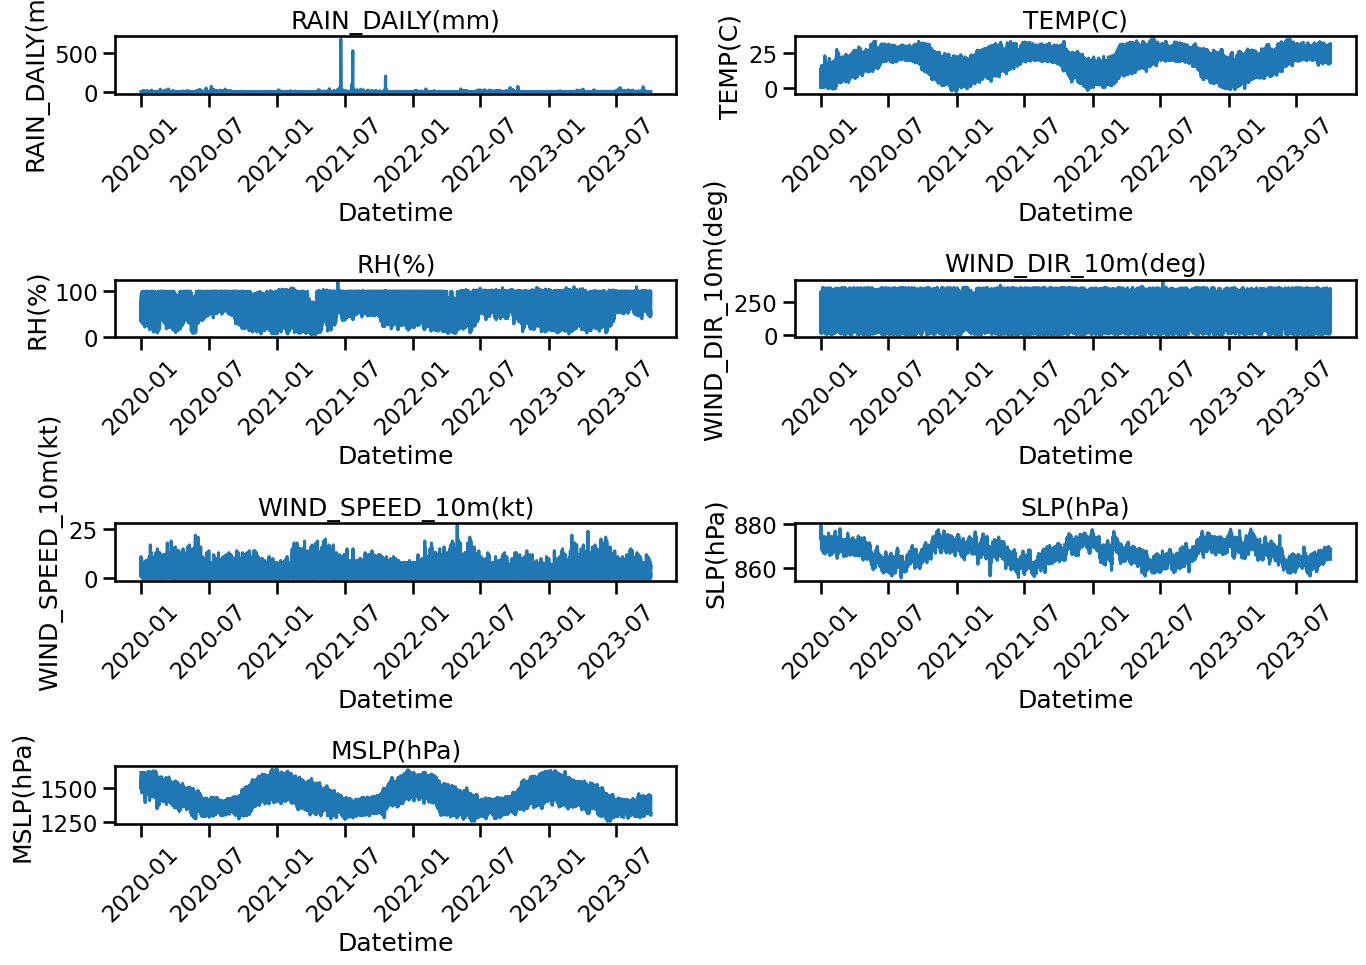

In [15]:
# Reload imputed or cleaned data
file_path = r"C:\Users\karan\OneDrive\Desktop\SPPU KARAN CODE JUNE 2025\imputed_data.csv"
data = pd.read_csv(file_path)

# Convert DATETIME column if needed
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

# Variables to visualize
columns_to_plot = ['RAIN_DAILY(mm)', 'TEMP(C)', 'RH(%)', 'WIND_DIR_10m(deg)', 
                   'WIND_SPEED_10m(kt)', 'SLP(hPa)', 'MSLP(hPa)']

# Create line plots
plt.figure(figsize=(14, 10))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(4, 2, i)
    plt.plot(data['DATETIME'], data[column])
    plt.title(column)
    plt.xlabel('Datetime')
    plt.ylabel(column)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [17]:
# Select features and target
features = ['TEMP(C)', 'RH(%)', 'WIND_DIR_10m(deg)', 'WIND_SPEED_10m(kt)', 'SLP(hPa)', 'MSLP(hPa)']
target = 'RAIN_DAILY(mm)'
data = df[features + [target]].dropna()

# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Sequence generation for LSTM
sequence_length = 24  # e.g., past 24 hours
X, y = [], []
for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i, :-1])
    y.append(data_scaled[i, -1])

X, y = np.array(X), np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')

# Callback for learning rate adjustment
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)

# Train model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_data=(X_test, y_test), callbacks=[lr_scheduler], verbose=1)


C:\Users\karan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
2842/2842 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 5.9359e-04 - val_loss: 5.2306e-04 - learning_rate: 0.0010
Epoch 2/100
2842/2842 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 4.9199e-04 - val_loss: 5.1252e-04 - learning_rate: 0.0010
Epoch 3/100
2842/2842 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 6.0565e-04 - val_loss: 5.0114e-04 - learning_rate: 0.0010
Epoch 4/100
2842/2842 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - loss: 5.5085e-04 - val_loss: 5.3470e-04 - learning_rate: 0.0010
Epoch 5/100
2842/2842 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 4.8806e-04 - val_loss: 5.0582e-04 - learning_rate: 0.0010
Epoch 6/100
2842/2842 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 5.2894e-04 - val_loss: 4.9239e-04 - learning_rate: 0.0010
Epoch 7/100
2842/2842 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 5.1116e-04 - val_loss: 5.1277e-04 - learning_rate: 5.0000e-04
Epoch 8/100
2842/2842 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 4.8965e-04 - val_loss: 4.7254e-04 - learning_rate: 5.0000e-04
Epoch 9/100
2842

In [19]:
# Predict on test data
y_pred = model.predict(X_test)

# Reconstruct original scale
X_test_last = X_test[:, -1, :]
combined = np.hstack((X_test_last, y_pred))
y_pred_actual = scaler.inverse_transform(combined)[:, -1]

# Actual target inverse transform
actual_combined = np.hstack((X_test_last, y_test.reshape(-1, 1)))
y_test_actual = scaler.inverse_transform(actual_combined)[:, -1]

# Compute evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)
mape = np.mean(np.abs((y_test_actual - y_pred_actual) / np.maximum(y_test_actual, 1e-6))) * 100

# Print evaluation
print(f"\nEvaluation Metrics:")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"R²   : {r2:.4f}")
print(f"MAPE : {mape:.2f}%")


711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Evaluation Metrics:
RMSE : 10.2733
MAE  : 2.5592
MSE  : 105.5402
R²   : 0.5748
MAPE : 101253712.28%


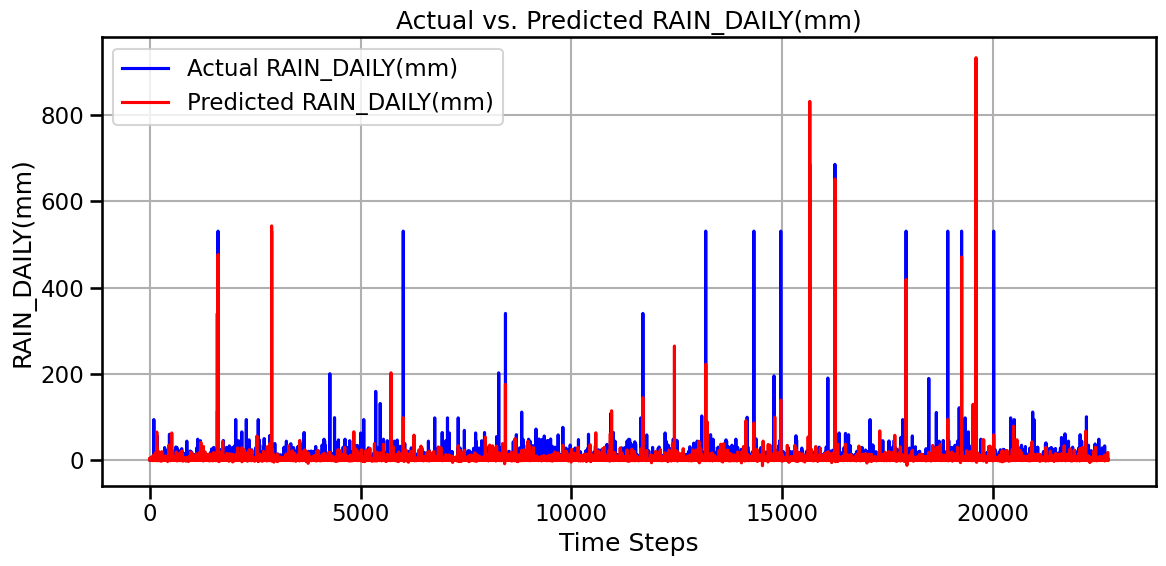

In [21]:
# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual RAIN_DAILY(mm)', color='blue')
plt.plot(y_pred_actual, label='Predicted RAIN_DAILY(mm)', color='red')
plt.xlabel('Time Steps')
plt.ylabel('RAIN_DAILY(mm)')
plt.title('Actual vs. Predicted RAIN_DAILY(mm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

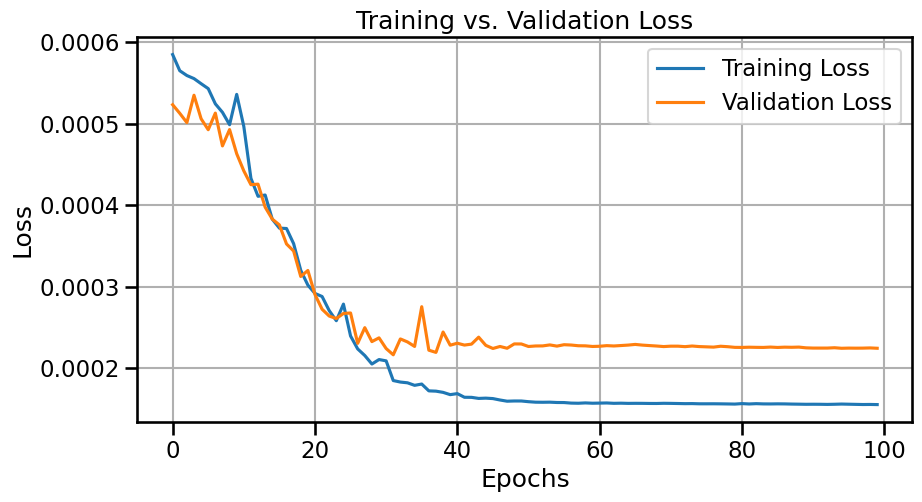

In [23]:
# Plot loss history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,355 (134.20 KB)

 Trainable params: 11,451 (44.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,904 (89.47 KB)